In [102]:
import pandas as pd
import copy
import math
import matplotlib.pyplot as plt

In [113]:
# Import & Clean CBSA Crosswalk
cbsa_crosswalk_df = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/cbsa-county-region-crosswalk.csv')
cbsa_crosswalk_df['FIPS State Code'] = cbsa_crosswalk_df['FIPS State Code'].astype(str).apply(lambda x: x.zfill(2))
cbsa_crosswalk_df['FIPS County Code'] = cbsa_crosswalk_df['FIPS County Code'].astype(str).apply(lambda x: x.zfill(3))
cbsa_crosswalk_df['FIPS'] = cbsa_crosswalk_df['FIPS State Code'] + cbsa_crosswalk_df['FIPS County Code']
cbsa_crosswalk_df = cbsa_crosswalk_df[['CBSA Code','FIPS']]

# Import, Clean, & Truncate Occupation Data
occ_df = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/census/Occupation_data/Occupation_ACSST5Y2020.S2405_2022-04-08T191431/ACSST5Y2020.S2405_data_with_overlays_2022-04-08T191426.csv',encoding='latin-1')
occs = occ_df.loc[0].tolist()
cols = occ_df.columns.tolist()
occ_dict = {cols[i]: occs[i] for i in range(len(cols))}
occ_df = occ_df.drop(0)
vars_to_keep = ['GEO_ID','NAME']
for k,v in occ_dict.items():
    if 'Estimate!!' in v and 'ALLOCATED' not in v:
        vars_to_keep.append(k)
occ_df = occ_df[vars_to_keep]
occ_df['GEO_ID'] = occ_df['GEO_ID'].str[-5:]
occ_df.columns = ['FIPS']+occ_df.columns.tolist()[1:]

# Combine and format dataframe
df = occ_df.merge(cbsa_crosswalk_df, on='FIPS', how='left')
df = df[~df['CBSA Code'].isna()]
df = df.reset_index()
df = df[df.columns.tolist()[1:]]
cols = df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
df = df[cols]
cols = []
for col in df.columns:
    if col in occ_dict:# and col != 'NAME':
        s = occ_dict[col].split('!')
        if len(s) > 5 or col == 'S2405_C01_001E':
            cols.append(col)
    else:
        cols.append(col)
df = df[cols]
cols[2] = 'employed_pop'
df.columns = cols

# Aggregate to CBSAs
df_agg = copy.deepcopy(df)
df_agg['employed_pop'] = df_agg['employed_pop'].astype(float)
for col in cols:
    if col in occ_dict:
        df_agg[col] = df_agg[col].replace('-','0')
        df_agg[col] = pd.to_numeric(df_agg[col]) 
        df_agg[col] = df_agg[col].astype(float)#*df_agg['employed_pop'].astype(float)
df_agg = df_agg.groupby(by='CBSA Code').sum()
for col in df_agg.columns:
    if col != 'employed_pop':
        df_agg[col] = df_agg[col] / df_agg['employed_pop']

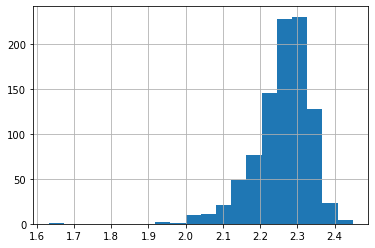

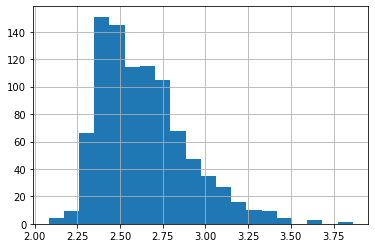

In [114]:
def shannon_entropy(array):
    e = [i*math.log(i) if i > 0 else 0 for i in array]
    return -sum(e)

cols = df_agg.columns.tolist()
cols_c01 = [i for i in cols if '_C01_' in i]
cols_c02_6 = [i for i in cols if ('_CO1' not in i and 'employed_pop' != i)]
df_agg_c01 = copy.deepcopy(df_agg[cols_c01])
df_agg_c02_6 = copy.deepcopy(df_agg[cols_c02_6])

entropy = []
for idx, row in df_agg_c01.iterrows():
    row_array = row.to_list()
    e = shannon_entropy(row_array)
    entropy.append(e)
df_agg_c01['entropy'] = entropy
df_agg_c01['entropy'].hist(bins=20)
plt.show()

entropy = []
for idx, row in df_agg_c02_6.iterrows():
    row_array = row.to_list()
    e = shannon_entropy(row_array)
    entropy.append(e)
df_agg_c02_6['entropy'] = entropy
df_agg_c02_6['entropy'].hist(bins=20)
plt.show()